<a href="https://colab.research.google.com/github/acts701/Audio/blob/main/241031_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
def p(var, _name=""):
    if _name != "": print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
        print(f'Type : {type(var)}')
        print(f'Values : {var}')
def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x,shape}')

In [4]:
#%%capture
#!pip install tensorflow==2.215.0
#!pip install keras==2.15.0

In [12]:
import tensorflow as tf
import keras
from keras import layers, datasets, models, utils
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,3]
plt.rcParams['font.size'] = '8'

tf.__version__,keras.__version__

('2.17.0', '3.4.1')

In [17]:
(x_train,_),(x_test,_)=keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train,x_test], axis=0)
#pst(mnist_digits) #Shape(70000, 28, 28) : mnist의 형태(batch_size,height,width)
# 신경망에서 이미지 처리를 할 때는 (batch_size,height,width,channels) 형태로 요구됨
# 따라서 차원을 늘려주는 함수 사용. -1을 붙이면 마지막 차원에 새로운 축을 추가
# 참고로 0이면 맨 앞에, 1,2, 등의 값이면 해당 위치에 차원이 추가됨
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") /255
#pst(mnist_digits) #Shape(70000, 28, 28, 1)
#print()
mnist_digits.shape

(70000, 28, 28, 1)


# Sampling
- Variational Inference가 적용되지 않은 AutoEncoder는 Latent space에 비대칭하여, 값의 범위 예측이 불가하다.
- 즉 AE의 encoding 결과 값의 범위는 예측 불가하다.
- sparse한 분포를 가져 정보가 퍼지는 경향이 있어 decoding 품질이 하락한다.

# Variational Inference
- Encoder가 만드는 분포를 정규 분포로 제한하자.
- encoder 출력(mean, variance)을 정규분포에서 sampling
- 분포의 대칭성 유도 및 범위 제한 가능
- 즉 평균과 로그 분산을 이용해 잠재 벡터 z를 샘플링

# VAE 구조
- Encoder : i-dim latent variable의 모수로 부터 sampling 하여 zi latent vector를 얻고
- Decoder : zi로 부터 ixel Bernoulli 분포인 Image 생성
- epsilon : Stochastic node의 backpropagation 즉 미분이 가능하게 만들기 위해 사용하는 reparameterization trick

# stochastic node
- 확률적 노드는 확률 모델에서 무작위 변수를 나타내는 역할. 결정론적 노드와 달리 고정된 출력이 아닌 무작위성

# Bernoulli 분포
- random variable의 1회 실행결과가 1과 0의 2가지 이진값으로만 이루어진 분포

# 미분이 가능한 이유
- 기울기 즉 한 점에서의 변화율을 정의하는데 무작위 변수가 있는 경우, 출력이 일정한 패턴이나 규칙 없이 변하기 때문에 기울기를 계산할 수 없음
- Stochastic node를 stochastic + deterministic로 분해
    - Deterministic 부분으로 역전파 가능

In [19]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        # 텐서의 각 차원 중 첫 번째 차원, 즉 배치 크기를 추출하는 것
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
- Decoder가 잘 복원할 수 있는 z를, sampling 할 수 있는 최적의 p(z|x)를 찾고 싶지만, 너무 어려워 최적의 p(z|x) 대신할 q(z|x)를 찾는 것 -> Variational Inference
- q : encoder가 만드는 분
- p : latent space 분포

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 3136)           │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │         50,192 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

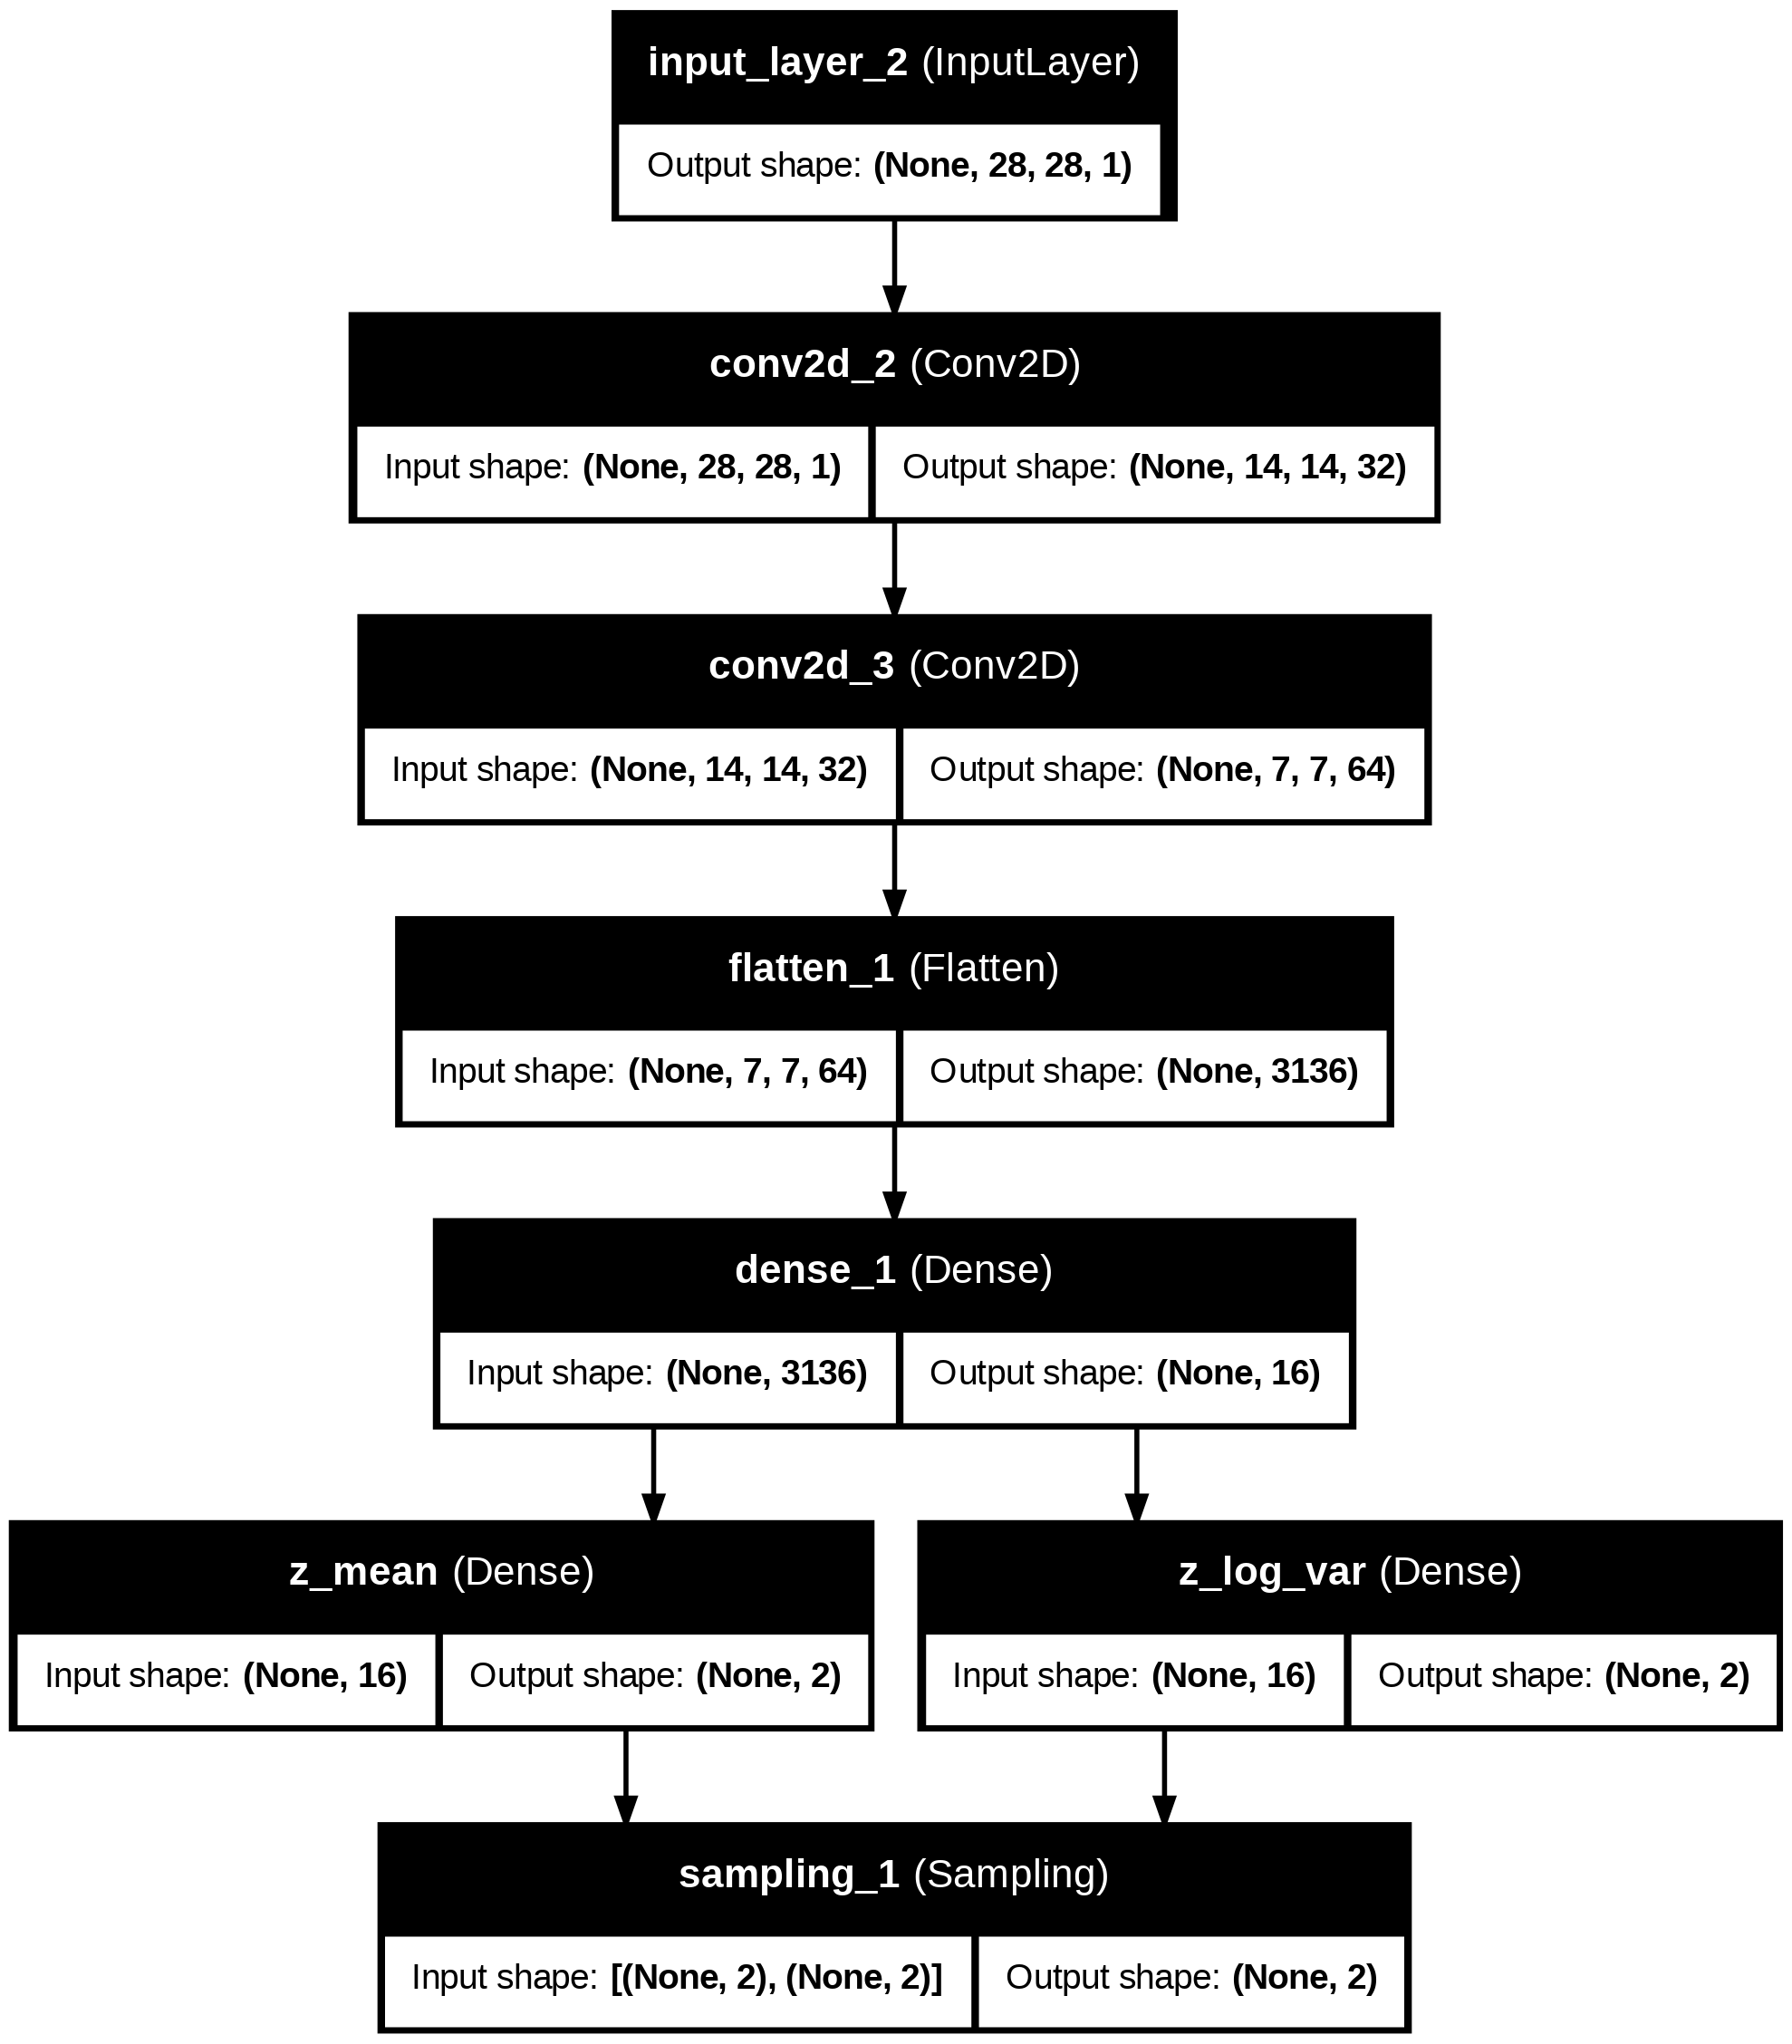

In [23]:
latent_dim = 2
def Encoder():
    inputs = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    # 가정한 확률 분포의 모수
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    # 모수로 부터 z 샘플링
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name= 'encoder')
    return encoder

encoder = Encoder()
encoder.summary()
utils.plot_model(encoder, show_layer_names=True, show_shapes=True)

# Decoder
- sampling 된 z를 decoding 하여 새로운 imange 추론(inference)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

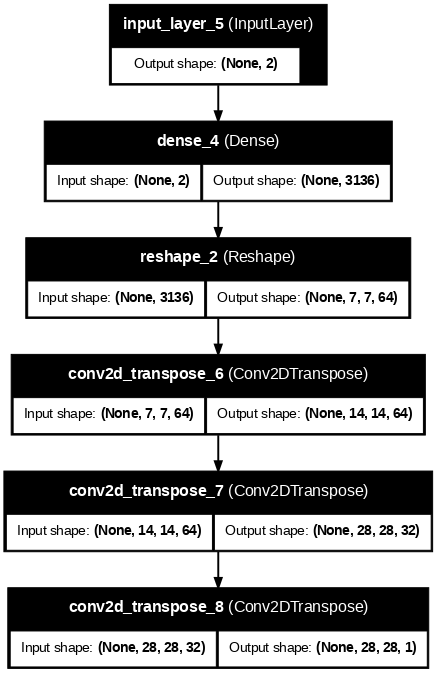

In [26]:
from json import decoder
def Decoder():
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7*7*64, activation='relu')(inputs)
    x = layers.Reshape((7,7,64))(x)
    # Conv2DTranspose : upsampling
    x = layers.Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
    x = layers.Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)
    outputs = layers.Conv2DTranspose(1,3,activation='sigmoid', padding='same')(x)
    decoder = keras.Model(inputs, outputs, name='decoder')
    return decoder

decoder = Decoder()
decoder.summary()
utils.plot_model(decoder, show_layer_names=True,show_shapes=True, dpi=70)

# KL Divergence
-

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tupe):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                 keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28*28
            # KL-Divergence 계산
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5